<a href="https://colab.research.google.com/github/RATFIVE/GEOMAR-DeepLearning/blob/main/app/backend/small-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

## Clone the data from GitHub

In [2]:
import os
if not os.path.exists('GEOMAR-DeepLearning'):
    print(f'GEOMAR-DeepLearning does not exist')
    !git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git
    %cd GEOMAR-DeepLearning/app/backend
    !git pull
    !pip install -r requirements.txt
else:
    print(f'GEOMAR-DeepLearning exists')
    %cd GEOMAR-DeepLearning/app/backend
    !git pull
    !pip install -r requirements.txt

GEOMAR-DeepLearning exists
/content/GEOMAR-DeepLearning/app/backend
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 79.67 KiB | 448.00 KiB/s, done.
From https://github.com/RATFIVE/GEOMAR-DeepLearning
   c5f4c91..19aecf1  main       -> origin/main
Updating c5f4c91..19aecf1
Fast-forward
 app/backend/small-model.ipynb | 815 +++++++++++++++++++++-----------------------------------------
 1 file changed, 270 insertions(+), 545 deletions(-)


## Import Libaries

In [3]:
# import all necessary libraries
import copy
import os
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import datetime
from utils.Copernicus import AdvancedCopernicus
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
from tqdm import tqdm
# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)



# Display all columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Import Data

In [4]:
START_DATE = '2025-02-01'
END_DATE = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
OUTPUT_FILENAME = 'output.nc'

BBOX= {
    # "min_lon":10.038345850696412,
    # "max_lon":10.365962458698567,
    # "min_lat":54.27381478077755,
    # "max_lat":54.52976525577923,

    "minimum_longitude":9.85083510071235,
    "maximum_longitude":10.926709174713364,
    "minimum_latitude":54.25206332481298,
    "maximum_latitude":54.97306793985031,

    "target_min_lon":10.156,
    "target_max_lon":10.170,
    "target_min_lat":54.354,
    "target_max_lat":54.365
    }

In [5]:
copernicus = AdvancedCopernicus()
def load_ocean_data(variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
                    minimum_longitude=BBOX["minimum_longitude"],
                    maximum_longitude=BBOX["maximum_longitude"],
                    minimum_latitude=BBOX["minimum_latitude"],
                    maximum_latitude=BBOX["maximum_latitude"],
                    delete_file=True,
                    output_filename='output'):

    output_range = maximum_longitude - minimum_longitude
    output_filename = f'{output_filename}-{START_DATE}-{output_range}.nc'

    if os.path.exists(output_filename):
        print(f'File {output_filename} already exists')
        return output_filename

    data = copernicus.get_subset(
        dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
        dataset_version="202411",
        variables=variables,
        minimum_longitude=minimum_longitude,
        maximum_longitude=maximum_longitude,
        minimum_latitude=minimum_latitude,
        maximum_latitude=maximum_latitude,
        start_datetime=START_DATE,
        end_datetime=END_DATE,
        minimum_depth=0.5016462206840515,
        maximum_depth=0.5016462206840515,
        coordinates_selection_method="strict-inside",
        disable_progress_bar=False,
        output_filename=output_filename,
        delete_file=delete_file)

    return data.to_dataframe().reset_index()

training_data = load_ocean_data(
    variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
    minimum_longitude=BBOX["minimum_longitude"],
    maximum_longitude=BBOX["maximum_longitude"],
    minimum_latitude=BBOX["minimum_latitude"],
    maximum_latitude=BBOX["maximum_latitude"], delete_file=False, output_filename='training'
)

target_data = load_ocean_data(
    variables=["sla"],
    minimum_longitude=BBOX["target_min_lon"],
    maximum_longitude=BBOX["target_max_lon"],
    minimum_latitude=BBOX["target_min_lat"],
    maximum_latitude=BBOX["target_max_lat"], delete_file=False, output_filename='target'
)


# Check if training_data is a class str
if isinstance(training_data, str):
    # Read .nc file
    training_data = xr.open_dataset(training_data).to_dataframe().reset_index()
    print(f'Open Training Data as DataFrame')
else:
    print(f'Training Data is already a DataFrame')

if isinstance(target_data, str):
    # Read .nc file
    target_data = xr.open_dataset(target_data).to_dataframe().reset_index()
    print(f'Open Target Data as DataFrame')
else:
    print(f'Target Data is already a DataFrame')



File training-2025-02-01-1.075874074001014.nc already exists
File target-2025-02-01-0.013999999999999346.nc already exists
Open Training Data as DataFrame
Open Target Data as DataFrame


## IDA

In [6]:
def process_df(df):
    df = df.dropna(axis=1, how="all")
    df = df.dropna(axis=0, how="any")
    df = df[["time"] + [col for col in df.columns if col != "time"]]
    float_cols = df.select_dtypes(include=["float"]).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    df["time"] = pd.to_datetime(df["time"]).dt.tz_localize(None).dt.round("h")
    df = df.reset_index(drop=True)
    return df

In [7]:
training_data = process_df(training_data)
display(training_data.head(3))
display(training_data.info())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,-0.094585,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,-0.076631,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,-0.052973,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678815 entries, 0 to 678814
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   time       678815 non-null  datetime64[ns]
 1   depth      678815 non-null  float32       
 2   latitude   678815 non-null  float32       
 3   longitude  678815 non-null  float32       
 4   bottomT    678815 non-null  float32       
 5   mlotst     678815 non-null  float32       
 6   siconc     678815 non-null  float32       
 7   sithick    678815 non-null  float32       
 8   sla        678815 non-null  float32       
 9   so         678815 non-null  float32       
 10  sob        678815 non-null  float32       
 11  thetao     678815 non-null  float32       
 12  uo         678815 non-null  float32       
 13  vo         678815 non-null  float32       
 14  wo         678815 non-null  float32       
dtypes: datetime64[ns](1), float32(14)
memory usage: 41.4 MB


None

In [8]:
target_data = process_df(target_data)
target_data.groupby(by=["time", 'latitude', 'longitude']).mean()
display(target_data.head(3))
display(target_data.info())
display(target_data['latitude'].unique())

,time,latitude,longitude,sla
0,2025-02-01 00:00:00,54.358276,10.152689,-0.120450
1,2025-02-01 01:00:00,54.358276,10.152689,-0.091966
2,2025-02-01 02:00:00,54.358276,10.152689,-0.065222


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       635 non-null    datetime64[ns]
 1   latitude   635 non-null    float32       
 2   longitude  635 non-null    float32       
 3   sla        635 non-null    float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 12.5 KB


None

array([54.358276], dtype=float32)

In [9]:
df_merged = pd.merge(training_data, target_data, on="time", how="inner", suffixes=("", "_target"))
display(df_merged.head(3))
display(df_merged.info())
display(df_merged.describe())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_target,longitude_target,sla_target
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,-0.094585,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06,54.358276,10.152689,-0.120450
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,-0.076631,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07,54.358276,10.152689,-0.091966
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,-0.052973,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07,54.358276,10.152689,-0.065222


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678815 entries, 0 to 678814
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   time              678815 non-null  datetime64[ns]
 1   depth             678815 non-null  float32       
 2   latitude          678815 non-null  float32       
 3   longitude         678815 non-null  float32       
 4   bottomT           678815 non-null  float32       
 5   mlotst            678815 non-null  float32       
 6   siconc            678815 non-null  float32       
 7   sithick           678815 non-null  float32       
 8   sla               678815 non-null  float32       
 9   so                678815 non-null  float32       
 10  sob               678815 non-null  float32       
 11  thetao            678815 non-null  float32       
 12  uo                678815 non-null  float32       
 13  vo                678815 non-null  float32       
 14  wo  

None

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_target,longitude_target,sla_target
count,678815,678815.000000,678815.000000,678815.000000,678815.000000,678815.000000,6.788150e+05,6.788150e+05,678815.000000,678815.000000,678815.000000,678815.000000,678815.000000,678815.000000,6.788150e+05,678815.000000,678815.000000,678815.000000
mean,2025-02-14 05:00:00,0.501646,54.660519,10.454241,3.926636,10.447370,3.717831e-08,3.181523e-07,-0.212800,15.277455,19.237347,3.304265,-0.030925,0.057830,-3.011630e-07,54.358337,10.152695,-0.218824
min,2025-02-01 00:00:00,0.501646,54.308277,9.874912,-0.591978,2.274687,0.000000e+00,0.000000e+00,-0.921992,8.571222,8.571222,-0.799094,-0.898166,-1.230932,-2.172987e-04,54.358276,10.152689,-0.816700
25%,2025-02-07 14:00:00,0.501646,54.524940,10.208244,3.494086,9.895411,0.000000e+00,0.000000e+00,-0.377381,13.110721,18.876416,2.931525,-0.081694,-0.020746,-2.132465e-09,54.358276,10.152689,-0.402988
50%,2025-02-14 05:00:00,0.501646,54.658272,10.458243,3.881343,10.015556,0.000000e+00,0.000000e+00,-0.202270,15.575070,19.661116,3.353209,-0.016677,0.024250,3.496042e-07,54.358276,10.152689,-0.208382
75%,2025-02-20 20:00:00,0.501646,54.791603,10.680465,4.433654,10.148015,0.000000e+00,0.000000e+00,-0.046212,17.753047,20.360518,3.759243,0.028867,0.091940,1.406680e-06,54.358276,10.152689,-0.035334
max,2025-02-27 10:00:00,0.501646,54.958267,10.902686,7.357439,33.155102,1.039391e-02,9.997947e-02,0.236108,20.839090,23.257256,4.939826,0.761376,1.805505,5.789600e-05,54.358276,10.152689,0.213716
std,NaN,0.001466,0.223082,0.276954,0.731058,2.813814,1.864010e-05,1.724997e-04,0.208469,2.965096,2.149148,0.631456,0.119495,0.178665,9.778852e-06,0.093750,0.036819,0.224264


## EDA

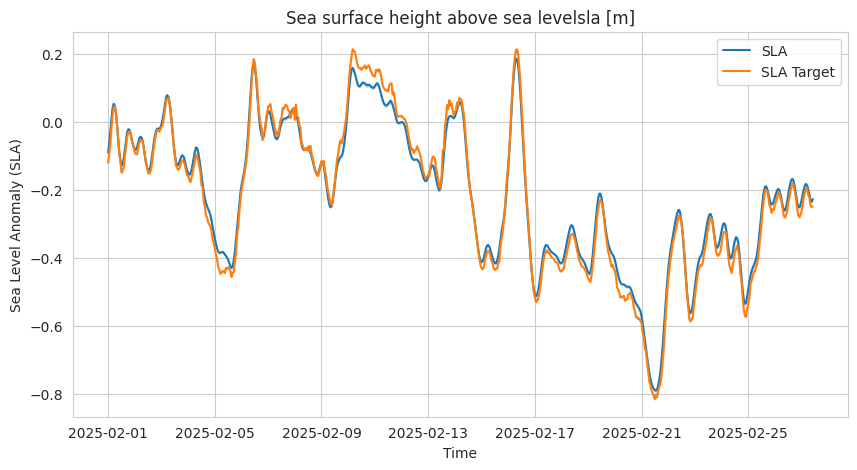

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for Seaborn
sns.set_style("whitegrid")

# Erstellen der Plot-Figur
plt.figure(figsize=(10, 5))

# Plot der SLA-Daten
sns.lineplot(x=df_merged["time"], y=df_merged["sla"], label="SLA")

# Plot der SLA Target-Daten
sns.lineplot(x=df_merged["time"], y=df_merged["sla_target"], label="SLA Target")

# Achsen und Titel setzen
plt.title("Sea surface height above sea levelsla [m]")
plt.xlabel("Time")
plt.ylabel("Sea Level Anomaly (SLA)")

# Legende anzeigen
plt.legend()

# Diagramm anzeigen
plt.show()


## Stationary

In [11]:
# df_target = df_merged["sla_target"]

# rolling_mean = df_target.rolling(window = 7).mean(numeric_only=True)
# rolling_std = df_target.rolling(window = 7).std(numeric_only=True)
# plt.plot(df_target, color = 'blue', label = 'Original')
# plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
# plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
# plt.legend(loc = 'best')
# plt.title('Rolling Mean & Rolling Standard Deviation')
# plt.show()

In [12]:

"""
from statsmodels.tsa.stattools import adfuller
def print_df_stats(series, order):
    x=series
    if (order>0):
        x=x.diff(order)[order:]
    result = adfuller(x)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

print_df_stats(df_target, 0)
print_df_stats(df_target, 1)
"""

"\nfrom statsmodels.tsa.stattools import adfuller\ndef print_df_stats(series, order):\n    x=series\n    if (order>0):\n        x=x.diff(order)[order:]\n    result = adfuller(x)\n    print('ADF Statistic: {}'.format(result[0]))\n    print('p-value: {}'.format(result[1]))\n    print('Critical Values:')\n    for key, value in result[4].items():\n        print('\t{}: {}'.format(key, value))\n\nprint_df_stats(df_target, 0)\nprint_df_stats(df_target, 1)\n"

In [13]:
# from statsmodels.tsa.stattools import acf, pacf

# diff_series=df_target.diff(2)[2:]

# lag_acf=acf(diff_series, nlags=7)
# lag_pacf=pacf(diff_series, nlags=7, method='ols')
# plt.figure(figsize=(20,10))
# plt.subplot(121)
# plt.plot(lag_acf)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.axhline(y=1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.title('Autocorrelation Function')
# plt.subplot(122)
# plt.plot(lag_pacf)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.axhline(y=1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.title('Partial Autocorrelation Function')

In [14]:
cols = [col for col in df_merged.columns if df_merged[col].dtype in [np.float64, np.float32]]
cols

['depth',
 'latitude',
 'longitude',
 'bottomT',
 'mlotst',
 'siconc',
 'sithick',
 'sla',
 'so',
 'sob',
 'thetao',
 'uo',
 'vo',
 'wo',
 'latitude_target',
 'longitude_target',
 'sla_target']

## Transform Data to 2D-Array

In [18]:

# Assuming 'df' is your DataFrame
df = df_merged.copy()
# 1. Convert time to datetime (if not already)
df['time'] = pd.to_datetime(df['time'])

# Round latitudes and longitudes
df['latitude'] = df['latitude']
df['longitude'] = df['longitude']

# 2. Get unique time points (hourly)
unique_times = df['time'].dt.strftime('%Y-%m-%d %H:00:00').unique()

df = df.drop(columns=["sla_target", "sla", "latitude_target", "longitude_target"])


display(df.head(3))
display(df.info())

print(f'Number of Unique latituds: {len(df["latitude"].unique())}')
print(f'Number of Unique longitudes: {len(df["longitude"].unique())}')

# 3. Create function to map lat/lon to grid coordinates
def map_coordinates_to_grid(df):
    # Get unique latitudes and longitudes
    latitudes = df['latitude'].unique()
    longitudes = df['longitude'].unique()

    # Create a grid, map latitude/longitude to a 2D grid
    latitude_map = {lat: idx for idx, lat in enumerate(latitudes)}
    longitude_map = {lon: idx for idx, lon in enumerate(longitudes)}
    #print(latitude_map)
    return latitude_map, longitude_map, len(latitudes), len(longitudes)

# 4. Create RGB image for each hour
def create_image_for_time(df, latitude_map, longitude_map, img_height, img_width):


    # get cols wich are numerical
    cols = [col for col in df.columns if df[col].dtype in [np.float64, np.float32]]

    # Remove latitude and longitude from cols
    cols.remove('latitude')
    cols.remove('longitude')
    #print(cols)

    # Normalize the values of uo, wo, and vo to [0, 255]
    #scaler = MinMaxScaler((0, 255))
    #df[cols] = scaler.fit_transform(df[cols])

    # Initialize a 2D array for every feature
    image = np.zeros((img_height, img_width, len(cols)), dtype=np.float32)

    for _, row in df.iterrows():
        #print(row)
        #print(row['latitude'])
        lat_idx = latitude_map[row['latitude']]
        lon_idx = longitude_map[row['longitude']]

        # Assign values of the cols to the corresponding pixel
        for col in cols:
            image[lat_idx, lon_idx, cols.index(col)] = row[col]

    return image

learning_data = {}
# 5. Loop through each unique time point and create an image
for i, time_point in tqdm(enumerate(unique_times), desc='Creating 2D-Array Data', total=len(unique_times)):
    # Filter data for the given time
    time_data = df[df['time'].dt.strftime('%Y-%m-%d %H:00:00') == time_point]

    # Map coordinates to grid
    latitude_map, longitude_map, img_height, img_width = map_coordinates_to_grid(time_data)

    # Create RGB image for this timepoint
    image = create_image_for_time(time_data, latitude_map, longitude_map, img_height, img_width)

    learning_data[time_point] = np.array(image)

    """
    # Save or display the image
    plt.imshow(image)
    plt.title(f'Image for {time_point}')
    plt.axis('off')  # Turn off axis labels
    #plt.savefig(f'image_{time_point}.png')  # Save the image
    plt.show()
    """

    #print(image.shape)
    if i >= 100:
      break

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,so,sob,thetao,uo,vo,wo
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678815 entries, 0 to 678814
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   time       678815 non-null  datetime64[ns]
 1   depth      678815 non-null  float32       
 2   latitude   678815 non-null  float32       
 3   longitude  678815 non-null  float32       
 4   bottomT    678815 non-null  float32       
 5   mlotst     678815 non-null  float32       
 6   siconc     678815 non-null  float32       
 7   sithick    678815 non-null  float32       
 8   so         678815 non-null  float32       
 9   sob        678815 non-null  float32       
 10  thetao     678815 non-null  float32       
 11  uo         678815 non-null  float32       
 12  vo         678815 non-null  float32       
 13  wo         678815 non-null  float32       
dtypes: datetime64[ns](1), float32(13)
memory usage: 38.8 MB


None

Number of Unique latituds: 40
Number of Unique longitudes: 38


Creating 2D-Array Data:  16%|█▌        | 100/635 [04:05<21:52,  2.45s/it]


In [43]:
# Get the target column with corresponding the time
df_target = df_merged.loc[:,['time', 'sla_target']]

# Group by time to get unique timestamps
df_target = df_target.groupby(by=['time']).mean().reset_index()
df_target.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        635 non-null    datetime64[ns]
 1   sla_target  635 non-null    float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 7.6 KB


In [44]:
df_target = df_target.loc[:100,]


df_target['time'] = pd.to_datetime(df_target['time']).dt.strftime('%Y-%m-%d %H:00:00')
print(df_target.info())
display(df_target.head(15))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        101 non-null    object 
 1   sla_target  101 non-null    float32
dtypes: float32(1), object(1)
memory usage: 1.3+ KB
None


,time,sla_target
0,2025-02-01 00:00:00,-0.120450
1,2025-02-01 01:00:00,-0.091966
2,2025-02-01 02:00:00,-0.065222
3,2025-02-01 03:00:00,-0.014131
4,2025-02-01 04:00:00,0.020769
5,2025-02-01 05:00:00,0.042144
6,2025-02-01 06:00:00,0.045322
7,2025-02-01 07:00:00,0.031030
8,2025-02-01 08:00:00,-0.009408
9,2025-02-01 09:00:00,-0.048037


In [45]:
df_model = pd.DataFrame([learning_data]).T.reset_index()

# rename column 0 to values
df_model.columns = ['time', 'values']

# Convert time to string
#df_model['time'] = df_model['time'].astype(str)

# Convert time to datetime
df_model['time'] = pd.to_datetime(df_model['time']).dt.strftime('%Y-%m-%d %H:00:00')
df_model.info()
df_model = pd.merge(df_model, df_target, on='time', how='inner')
df_model.info()
df_model.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    101 non-null    object
 1   values  101 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        101 non-null    object 
 1   values      101 non-null    object 
 2   sla_target  101 non-null    float32
dtypes: float32(1), object(2)
memory usage: 2.1+ KB


,time,values,sla_target
0,2025-02-01 00:00:00,"[[[0.5016462, 3.9498742, 11.431097, 0.0, 0.0, ...",-0.120450
1,2025-02-01 01:00:00,"[[[0.5016462, 3.9476612, 11.449051, 0.0, 0.0, ...",-0.091966
2,2025-02-01 02:00:00,"[[[0.5016462, 3.9451876, 11.47271, 0.0, 0.0, 2...",-0.065222


In [47]:
learning_data = df_model['values']
learning_data = list(learning_data)
learning_data = np.array(learning_data)
print(learning_data.shape)

(101, 40, 38, 11)


In [50]:
target = df_model['sla_target']
target = list(target)
target = np.array(target)
print(target.shape)

(101,)


In [49]:
target

array(['time', 'sla_target'], dtype='<U10')

In [ ]:
number_of_data_points = len(learning_data)
print(number_of_data_points)

image_heigt = learning_data.shape[1]
print(image_heigt)

image_width = learning_data.shape[2]
print(image_width)

number_of_features = learning_data.shape[3]
print(number_of_features)

In [71]:
import numpy as np
import torch

def create_overlapping_windows(data, target, window_size=24, pred_size=24, stride=1):
    """
    Erstellt Overlapping Windows aus den Zeitseriendaten.

    Args:
        data (np.array): Eingabe mit Shape (T, 40, 38, 11)
        target (np.array): Wasserpegel mit Shape (T, 1)
        window_size (int): Länge des Eingabefensters
        pred_size (int): Länge des vorherzusagenden Zeitraums
        stride (int): Schrittweite zwischen Fenstern

    Returns:
        X_windows (torch.Tensor): Eingaben (Batch, window_size, 40, 38, 11)
        y_windows (torch.Tensor): Targets (Batch, pred_size)
    """
    X_windows = []
    y_windows = []

    T = data.shape[0]  # Anzahl der Zeitschritte

    for i in range(0, T - window_size - pred_size + 1, stride):
        X_windows.append(data[i:i + window_size])  # Letzte 24 Stunden
        y_windows.append(target[i + window_size: i + window_size + pred_size].flatten())  # Nächste 24 Stunden

    X_windows = np.array(X_windows)  # (Batch, 24, 40, 38, 11)
    y_windows = np.array(y_windows)  # (Batch, 24)

    return torch.tensor(X_windows, dtype=torch.float32), torch.tensor(y_windows, dtype=torch.float32)

# Dummy-Daten erzeugen
#T = 101  # 101 Zeitpunkte
#data = np.random.rand(T, 40, 38, 11)  # Shape (101, 40, 38, 11)
#target = np.random.rand(T, 1)  # Shape (101, 1)

# Overlapping Windows erstellen
X, y = create_overlapping_windows(learning_data, target, window_size=24, pred_size=24, stride=1)

print("X shape:", X.shape)  # (Batch, 24, 40, 38, 11)
print("y shape:", y.shape)  # (Batch, 24)


X shape: torch.Size([54, 24, 40, 38, 11])
y shape: torch.Size([54, 24])


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim

class OceanWaterLevelPredictor(nn.Module):
    def __init__(self, X_data, hidden_dim=64, num_layers=2):
        super(OceanWaterLevelPredictor, self).__init__()

        # Convolutional Block (räumliche Merkmale extrahieren)
        self.conv1 = nn.Conv2d(in_channels=11, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()


        # LSTM Block (zeitliche Abhängigkeiten lernen)
        # Calculate input size for LSTM
        # Assuming output of conv2 is (batch_size, 64, lat/2, lon/2) after pooling
        # You might need to adjust these dimensions based on your actual data and pooling layers.
        # For example if the dummy_input has dimensions (8, 24, 40, 38, 11),
        # the Conv2d and max pooling operation will result into (batch, 64, 10, 9)
        # which results in an input_size for the LSTM of 9 * 10 * 64 = 5760
        # (adjust to the dimensions of learning data)
        self.lstm_input_size = 9 * 10 * 64  # Adjust these based on CNN output size
        # Berechnung der CNN-Ausgabegröße mit Dummy-Daten
        self.lstm_input_size = self._get_lstm_input_size(X_data)
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Fully Connected Layer (Endvorhersage)
        self.fc = nn.Linear(hidden_dim, 24)  # 24 Stunden Vorhersage

    def _get_lstm_input_size(self, X_data):
        """Berechnet die korrekte input_size für das LSTM anhand der CNN-Ausgabegröße"""
        input_shape = X_data.shape
        #print(input_shape)  # Print the shape to inspect
        length_of_data = len(X_data)
        #print(length_of_data)  # Print the length to inspect

        # Check the number of dimensions and unpack accordingly
        if len(input_shape) == 5:
            batch_size, time_steps, lat, lon, features = (length_of_data, *input_shape[1:])  # Unpack for 5D input
        elif len(input_shape) == 4:  # Assuming 4D input (Batch, lat, lon, features)
            batch_size, lat, lon, features = (length_of_data, *input_shape[1:])
            time_steps = 1  # Set time_steps to 1 for 4D input
        else:
            raise ValueError(f"Unexpected input shape: {input_shape}. Expected 4 or 5 dimensions.")

        dummy_input = torch.randn(batch_size * time_steps, features, lat, lon)  # (Batch*Time, Features, H, W)

        dummy_input = torch.randn(batch_size * time_steps, features, lat, lon)  # (Batch*Time, Features, H, W)

        x = self.pool(self.relu(self.conv1(dummy_input)))
        x = self.pool(self.relu(self.conv2(x)))

        _, c, h, w = x.shape  # Output-Shape nach CNN
        return c * h * w  # LSTM-Eingangsgröße berechnen

    def forward(self, x):
        batch_size, time_steps, lat, lon, features = x.shape
        x = x.view(batch_size * time_steps, features, lat, lon)  # Kombiniere Zeit + Batch für CNN

        # CNN Feature Extraction
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Reshape for LSTM, calculating the correct input size
        x = x.view(batch_size, time_steps, -1)  # Reshape before LSTM

        # LSTM für Sequenzverarbeitung
        x, _ = self.lstm(x)

        # Letzten Zeitschritt nehmen und durch FC-Schicht für 24-Stunden-Prognose
        x = self.fc(x[:, -1, :])

        return x  # Ausgabeform: (Batch, 24)

# Testmodell
model = OceanWaterLevelPredictor(X_data=X)
#dummy_input = torch.randn(8, 24, 40, 38, 11)  # Batch=8, 24 Zeitpunkte, räumliche Größe (40,38), 11 Features
output = model(X)
print(output.shape)  # Erwartet: (8, 24)

torch.Size([54, 24])


In [73]:
from torch.utils.data import Dataset, DataLoader

class OceanDataset(Dataset):
    def __init__(self, data, target, window_size=24, pred_size=24, stride=1):
        self.X, self.y = create_overlapping_windows(data, target, window_size, pred_size, stride)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = OceanDataset(learning_data, target)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

for X_batch, y_batch in dataloader:
    print(X_batch.shape, y_batch.shape)  # (8, 24, 40, 38, 11) und (8, 24)
    break

torch.Size([8, 24, 40, 38, 11]) torch.Size([8, 24])


In [ ]:

dropout_results = [] # storing the results of the dropout experiment

def training(model, learning_data, target, criterion, optimizer, epochs, verbose=False):

    # Set device to GPU if available
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # Convert Numpy Arrays to Torch Tensor
    learning_data = torch.tensor(learning_data, dtype=torch.float32)
    target = torch.tensor(target, dtype=torch.float32)

    # Move data and model to device
    learning_data, target = learning_data.to(device), target.to(device)
    model.to(device)

    # Initialize best metrics and model
    best_eval_metric_val = -float('inf') # Initialize the best_eval_metric
    best_val_loss = float('inf') # Initialize the best_val_loss
    best_model = copy.deepcopy(model.state_dict()) # Initialize the best_model
    patience_counter_loss = 0  # Early stopping counter
    patience_counter_metric = 0  # Early stopping counter

    # DataLoader for batching
    dataset = OceanDataset(learning_data, target)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


    # Scheduler for learning rate adjustment (if val_loss does not improve for 'patience' epochs)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    train_losses, val_losses = [], [] # to visualize the drop_out_prob
    train_accuracies, val_accuracies = [], []
    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # Training loop
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, target)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss.item()  # Accumulate batch loss



        # Print status
        if verbose:
          if epoch % 19 == 0:
            print(f"| Epoch {epoch+1} | Train Loss: {epoch_loss / len(dataloader):.4f} |")


    # Load the best model
    #model.load_state_dict(best_model)
    #print(f"Best validation accuracy: {best_eval_metric_val:.4f}")

    #writer.close()
    return model

training(
    model=OceanWaterLevelPredictor(X_data=X),
    learning_data=learning_data,
    target=target,
    criterion=nn.MSELoss(),
    optimizer=optim.Adam(model.parameters(), lr=0.001),
    epochs=100,
    verbose=True
)


| Epoch 1 | Train Loss: 0.0237
| Epoch 20 | Train Loss: 0.0243
